In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Data/processed.csv')
df.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,year,month,day,hour,cluster
0,2022-01-01,11.021500,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,2022,1,1,0,4
1,2022-01-01,10.521500,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,2022,1,1,1,4
2,2022-01-01,10.721499,96.0,8.677092,0.0,0.0,0.0,0.0,1019.8,1018.69610,100.0,14.345898,197.52567,39.96,0.0,2022,1,1,2,4
3,2022-01-01,11.071500,97.0,9.138726,0.0,0.0,0.0,0.0,1019.7,1018.59784,100.0,14.587776,195.75124,42.12,0.0,2022,1,1,3,4
4,2022-01-01,11.221499,96.0,8.969191,0.0,0.0,0.0,0.0,1019.5,1018.39825,100.0,16.766108,194.93147,49.32,0.0,2022,1,1,4,4


In [4]:
df.isna().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
apparent_temperature    0
precipitation           0
rain                    0
showers                 0
snowfall                0
pressure_msl            0
surface_pressure        0
cloud_cover             0
wind_speed_10m          0
wind_direction_10m      0
wind_gusts_10m          0
is_day                  0
year                    0
month                   0
day                     0
hour                    0
cluster                 0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

### EDA

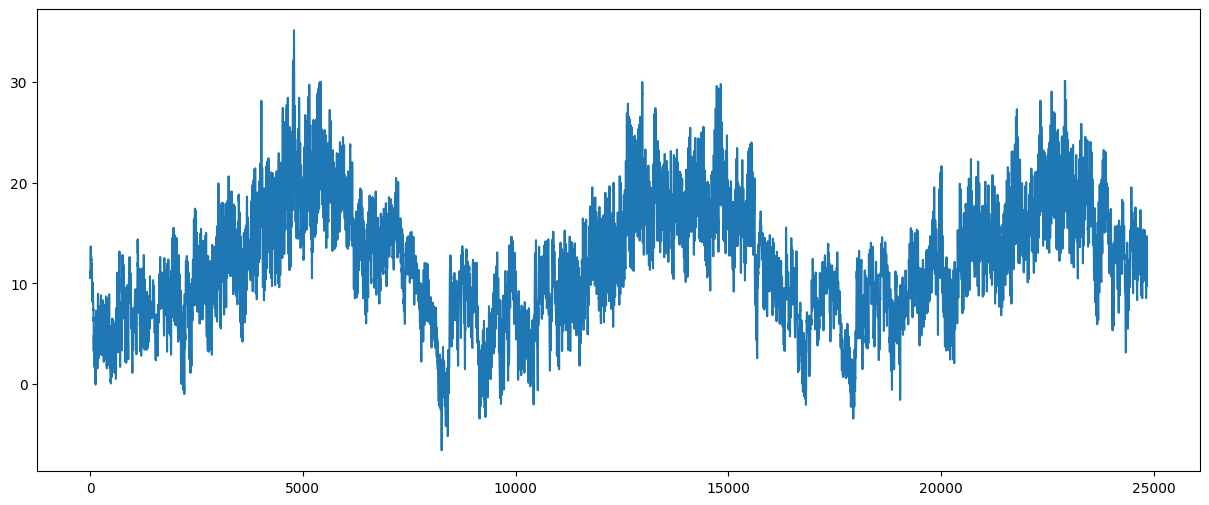

In [6]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['temperature_2m'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

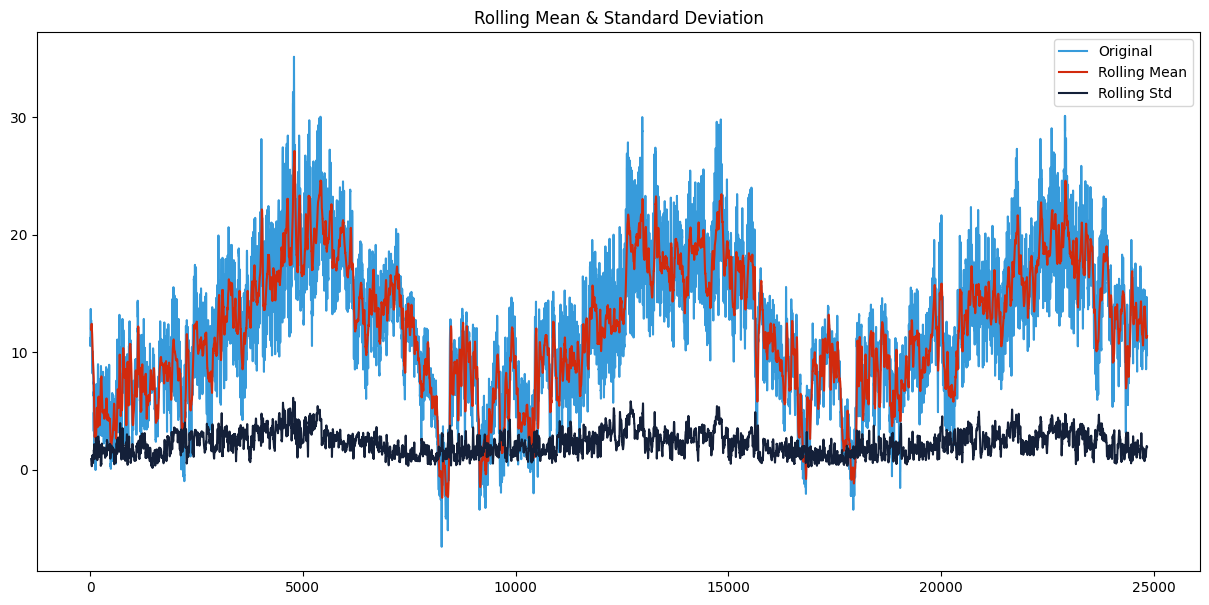

In [7]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["temperature_2m"], color='#379BDB', label='Original')
plt.plot(df["temperature_2m"].rolling(window=24).mean(), color='#D22A0D', label='Rolling Mean')
plt.plot(df["temperature_2m"].rolling(window=24).std(), color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

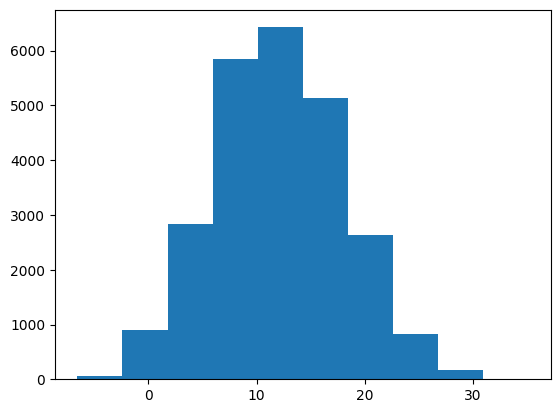

In [8]:
plt.hist(df['temperature_2m'])
plt.show()

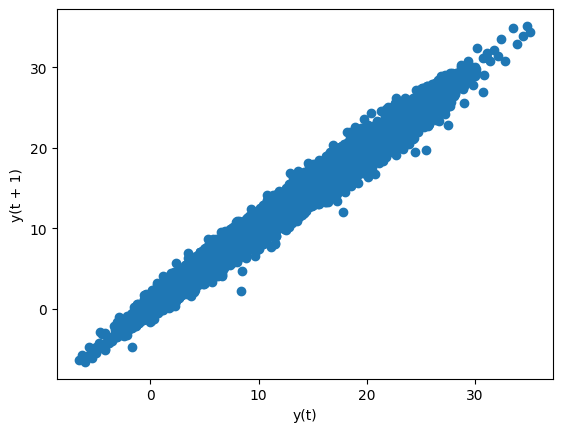

In [9]:
from pandas.plotting import lag_plot

lag_plot(df['temperature_2m'])
plt.show()

In [10]:
# Checking auto-correlation
from pandas import concat

btc_price = df['temperature_2m']
dataframe = concat([btc_price.shift(1), btc_price], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
result

,t,t+1
t,1.000,0.991
t+1,0.991,1.000


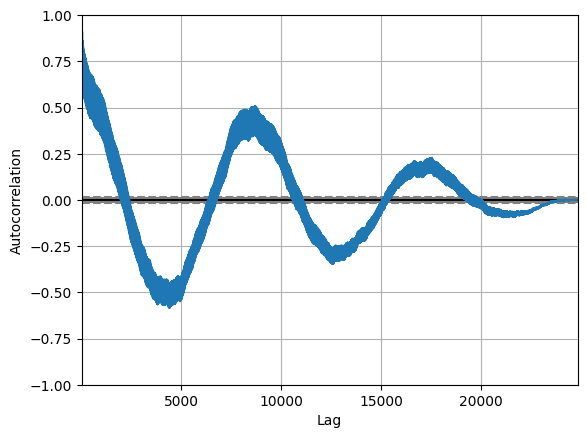

In [11]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['temperature_2m'])
plt.show()

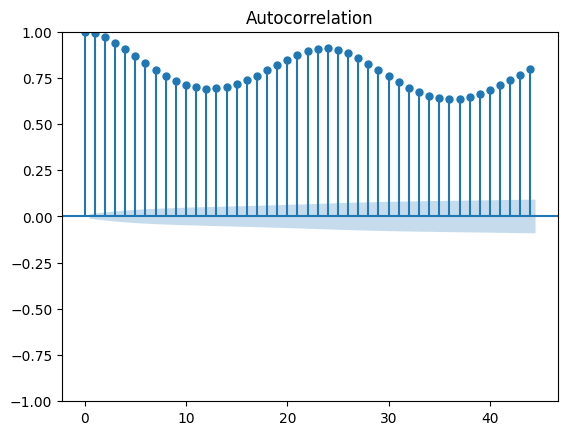

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['temperature_2m'])
plt.show()

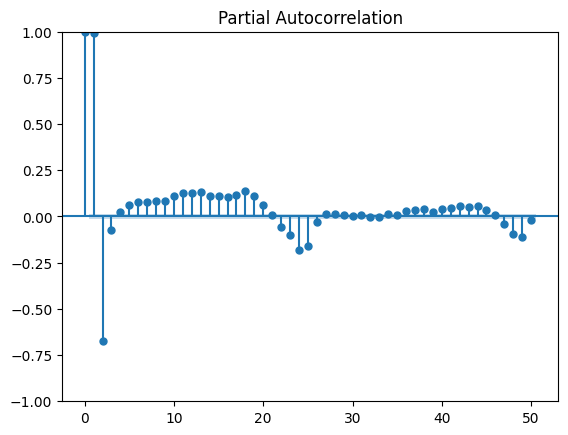

In [13]:
plot_pacf(df['temperature_2m'], lags=50)
plt.show()

### Data transformation

In [14]:
df = df.drop(['year', 'date'], axis = 1)
df.head(2)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster
0,11.0215,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,1,1,0,4
1,10.5215,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,1,1,1,4


<Axes: >

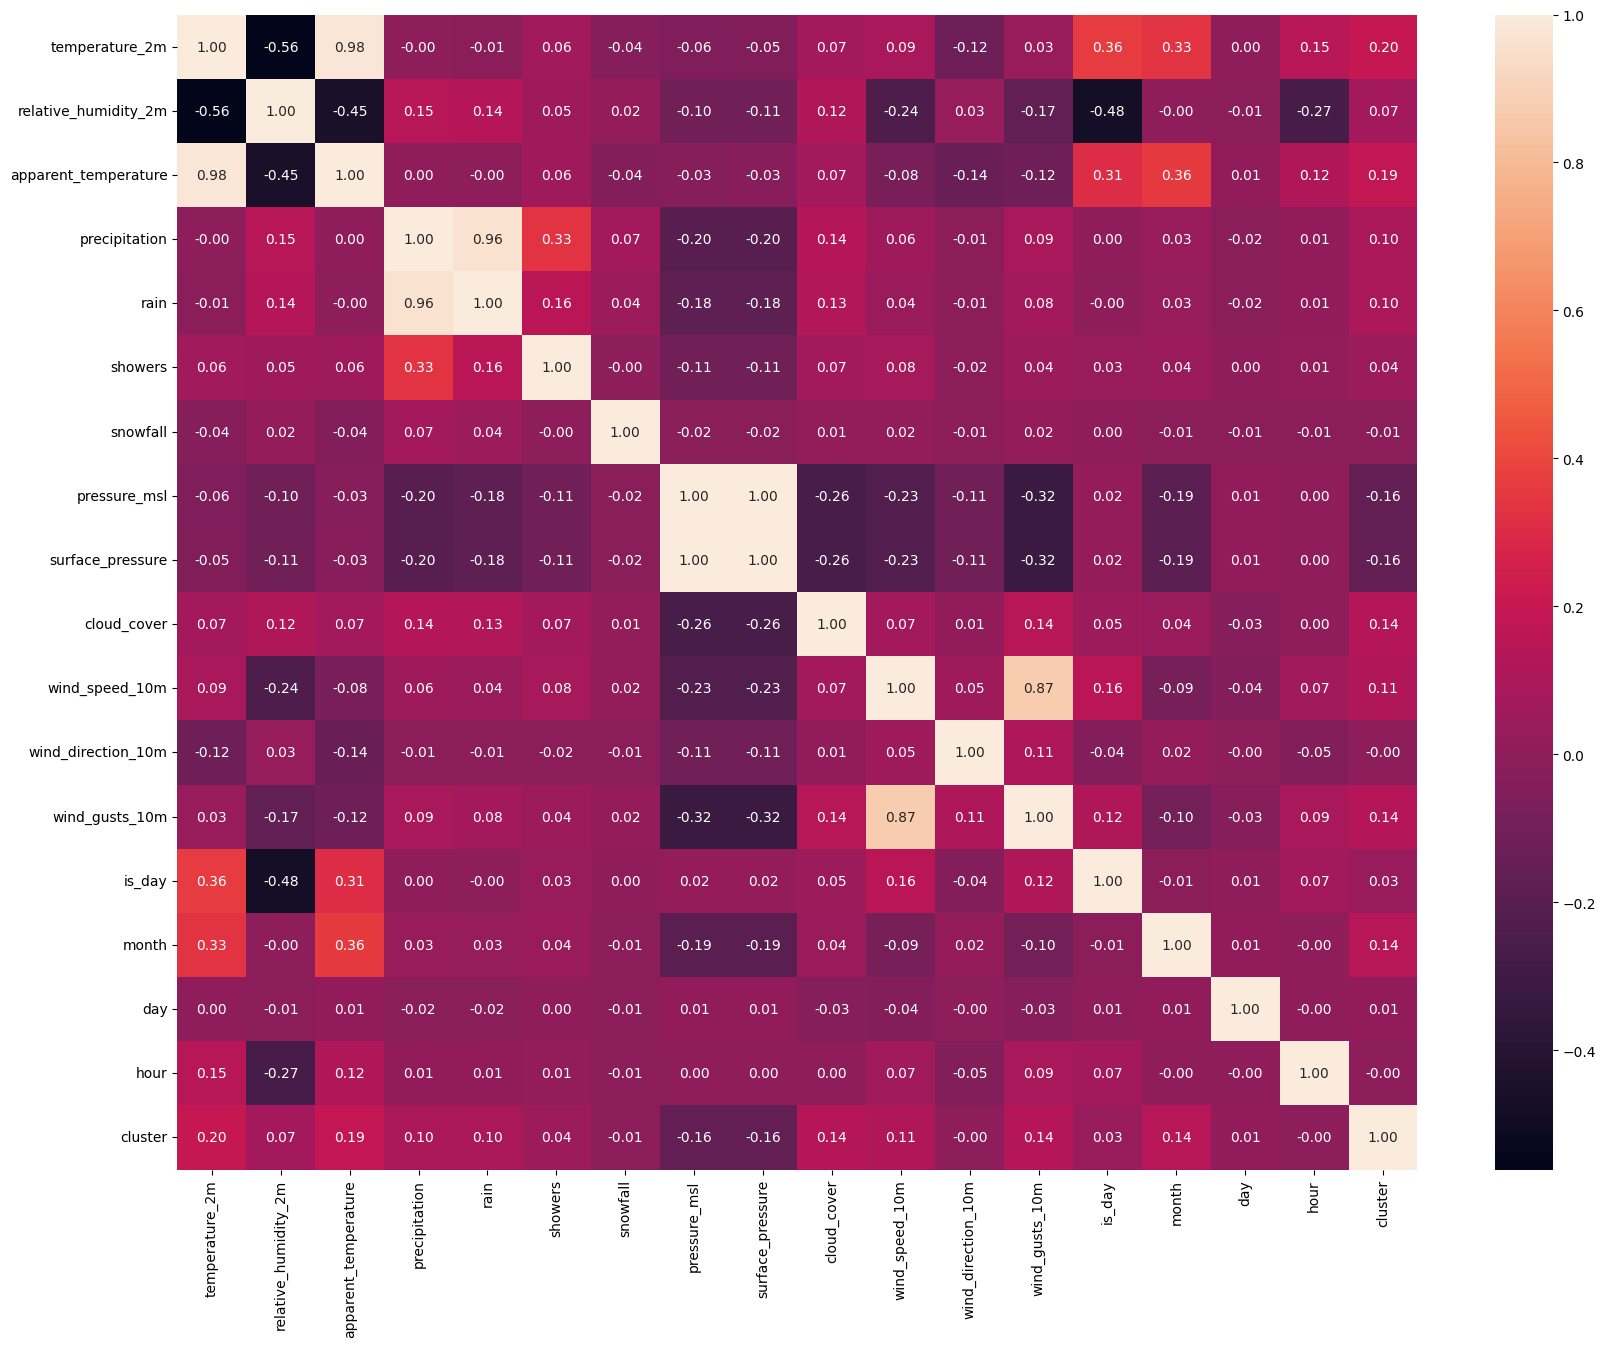

In [15]:
# Create correlation matrix heat map to check multi-collinearity between columns.

plt.figure(figsize = (20,15), dpi = 100)
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

### Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['temperature_2m'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.731155624107622
p-value: 6.59556623666626e-07


### Data Splitting and scaling

In [17]:
len(df.index) - (len(df.index) * 20 /100)

19872.0

In [18]:
train = df.iloc[:19872]
test = df.iloc[19872:]
test.reset_index(drop = True, inplace = True)

In [19]:
x_train = train.drop('temperature_2m', axis = 1)
y_train = train[['temperature_2m']]
x_test = test.drop('temperature_2m', axis = 1)
y_test = test[['temperature_2m']]

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19872, 17)
(19872, 1)
(4968, 17)
(4968, 1)


### Feature Selection

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the features
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [22]:
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(x_train, y_train)

c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(cv=5, random_state=42)

In [23]:
# Get the coefficients
feature_names = list(train.columns)
feature_names.remove('temperature_2m')
lasso_coefficients = lasso.coef_

# Identify selected features
selected_features_indices = np.where(lasso_coefficients != 0)[0]
selected_feature_names = [feature_names[i] for i in selected_features_indices]
selected_coefficients = lasso_coefficients[selected_features_indices]

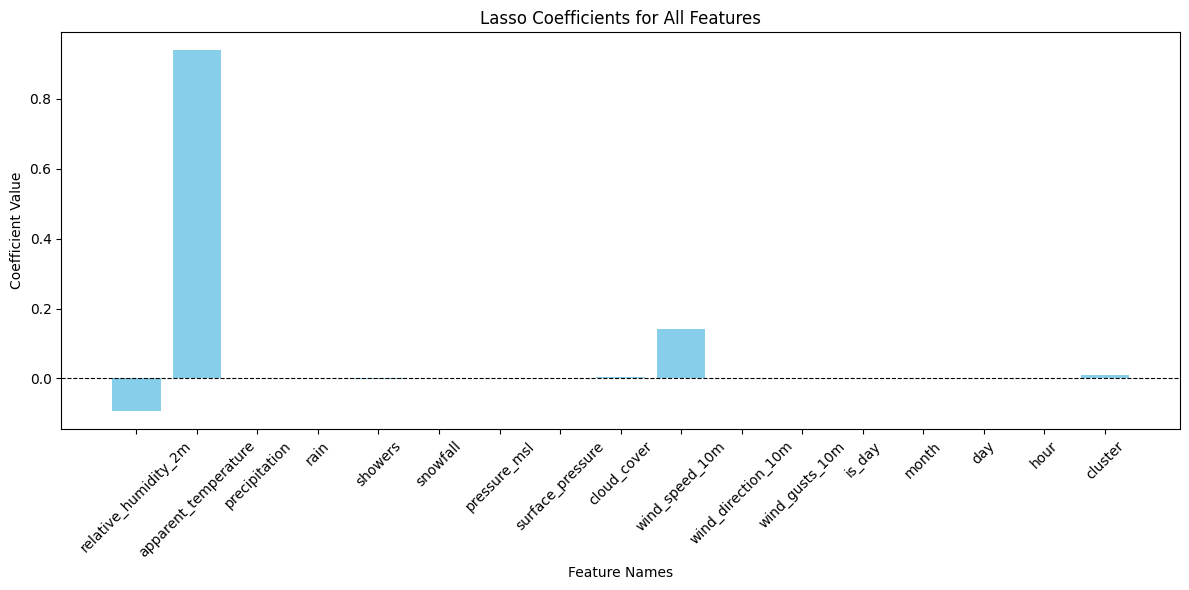

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso_coefficients, color='skyblue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Lasso Coefficients for All Features")
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

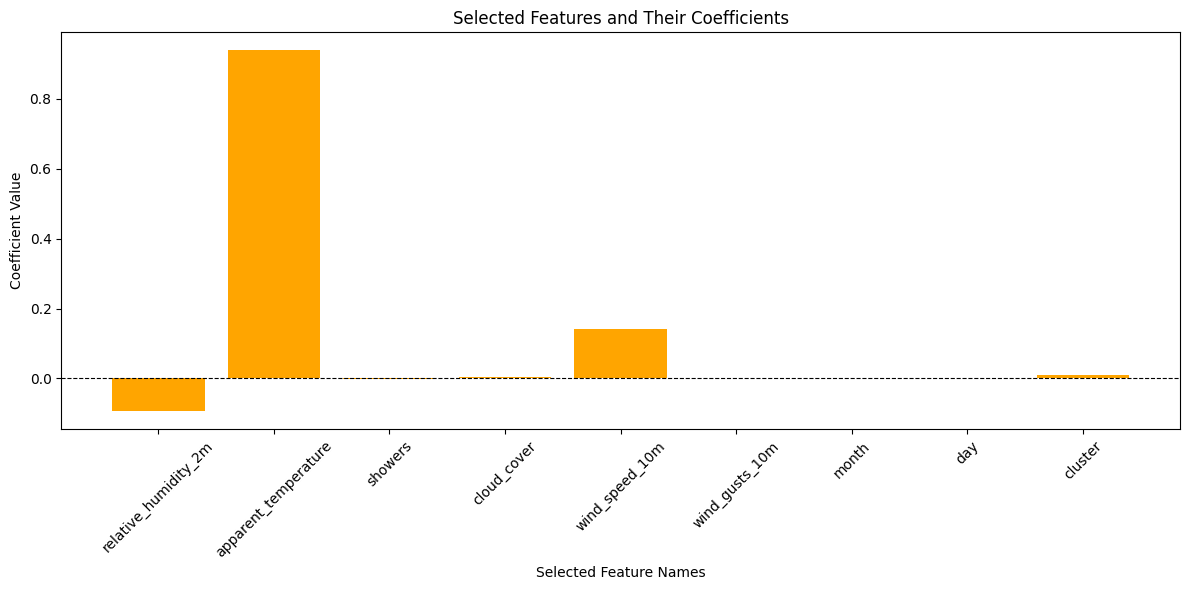

In [25]:
plt.figure(figsize=(12, 6))
plt.bar(selected_feature_names, selected_coefficients, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Selected Features and Their Coefficients")
plt.xlabel("Selected Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
selected_coefficients

array([-9.36722674e-02,  9.38153178e-01, -1.34462659e-03,  4.81696740e-03,
        1.42752265e-01,  2.75048703e-03,  1.22718058e-03,  1.04229328e-04,
        8.64622619e-03])

In [27]:
selected_features_indices

array([ 0,  1,  4,  8,  9, 11, 13, 14, 16])

In [28]:
x_train = x_train[:, selected_features_indices]
x_test = x_test[:, selected_features_indices]

### Machine learning

In [29]:
def mad_error(y_true, y_pred):
    # Ensure inputs are numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate absolute deviations
    absolute_deviation = np.abs(y_true - y_pred)
    
    # Compute the mean of absolute deviations
    mad_error = np.mean(absolute_deviation)
    
    return mad_error

In [30]:
df1 = df[['temperature_2m', 'apparent_temperature', 'showers', 'cloud_cover', 'wind_speed_10m', 'month', 'day', 'cluster']]

In [31]:
lagged_data = df1.copy()
for lag in range(1, 2):  # Create lags
    for col in df1.columns:
        lagged_data[f'{col}_lag_{lag}'] = df1[col].shift(lag)

In [32]:
for lag in range(1, 6):
    lagged_data[f'future_temp_{lag}'] = lagged_data['temperature_2m'].shift(-lag)

In [33]:
lagged_data = lagged_data.dropna()
lagged_data.reset_index(drop=True, inplace = True)

In [34]:
lagged_data.head(2)

,temperature_2m,apparent_temperature,showers,cloud_cover,wind_speed_10m,month,day,cluster,temperature_2m_lag_1,apparent_temperature_lag_1,showers_lag_1,cloud_cover_lag_1,wind_speed_10m_lag_1,month_lag_1,day_lag_1,cluster_lag_1,future_temp_1,future_temp_2,future_temp_3,future_temp_4,future_temp_5
0,10.521500,8.323380,0.0,19.0,14.707222,1,1,4,11.0215,8.542295,0.0,7.0,16.981165,1.0,1.0,4.0,10.721499,11.071500,11.221499,11.0715,10.8215
1,10.721499,8.677092,0.0,100.0,14.345898,1,1,4,10.5215,8.323380,0.0,19.0,14.707222,1.0,1.0,4.0,11.071500,11.221499,11.071500,10.8215,11.2715


In [35]:
split_len = round(len(lagged_data.index) * 0.8)
split_len

19867

In [36]:
train = lagged_data.iloc[:split_len]
test = lagged_data.iloc[split_len:]
test.reset_index(drop = True, inplace = True)

In [37]:
x_train = train.drop(['future_temp_1', 'future_temp_2', 'future_temp_3', 'future_temp_4', 'future_temp_5'], axis = 1)
y_train = train[['future_temp_1', 'future_temp_2', 'future_temp_3', 'future_temp_4', 'future_temp_5']]
x_test = test.drop(['future_temp_1', 'future_temp_2', 'future_temp_3', 'future_temp_4', 'future_temp_5'], axis = 1)
y_test = test[['future_temp_1', 'future_temp_2', 'future_temp_3', 'future_temp_4', 'future_temp_5']]

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19867, 16)
(19867, 5)
(4967, 16)
(4967, 5)


In [39]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [40]:
y_test_rescaled = y_scaler.inverse_transform(y_test)

In [41]:
import joblib
joblib.dump(x_scaler, 'x_scaler_temperature.joblib')
joblib.dump(y_scaler, 'y_scaler_temperature.joblib')

['y_scaler_temperature.joblib']

#### Linear Regression

In [46]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

LR = MultiOutputRegressor(LinearRegression())
LR.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [47]:
pred = LR.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [48]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [49]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[np.float64(0.40220696778650855), np.float64(0.7704953694239369), np.float64(1.145831915646026), np.float64(1.5214394233738784), np.float64(1.870342577356413)]
Average error:  1.1420632507173525


#### KNN

In [60]:
from sklearn.neighbors import KNeighborsRegressor

KNN = MultiOutputRegressor(KNeighborsRegressor())
KNN.fit(x_train, y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [61]:
pred = KNN.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [62]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [63]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.9934153469659754, 1.4523591048411517, 1.8956392827859072, 2.28871209716207, 2.6135182495535334]
Average error:  1.8487288162617275


#### DT

In [64]:
from sklearn.tree import DecisionTreeRegressor

DT = MultiOutputRegressor(DecisionTreeRegressor())
DT.fit(x_train, y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor())

In [65]:
pred = DT.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [66]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [67]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.6271493267565935, 1.1432446373464868, 1.6674013766458626, 2.2007416432454194, 2.574484876404268]
Average error:  1.642604372079726


#### Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

RF = MultiOutputRegressor(RandomForestRegressor())
RF.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [69]:
pred = RF.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [70]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [71]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.4036180376126435, 0.7556982539264848, 1.1201087051478438, 1.4939181400950794, 1.792945436771234]
Average error:  1.1132577147106573


#### Gradient Boosting

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

GB = MultiOutputRegressor(GradientBoostingRegressor())
GB.fit(x_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [73]:
pred = GB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [74]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [75]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.5417000562648079, 1.0009169248666758, 1.4235843941750015, 1.7910563192639384, 2.1068563440137567]
Average error:  1.372822807716836


#### Hist Gradient Boosting

In [76]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB = MultiOutputRegressor(HistGradientBoostingRegressor())
HGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [77]:
pred = HGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [78]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [79]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.40906757442706915, 0.7666335654620942, 1.1186043548224922, 1.4649985776897605, 1.748496457849212]
Average error:  1.1015601060501257


#### XGBoost

In [80]:
from xgboost import XGBRegressor

XGB = MultiOutputRegressor(XGBRegressor())
XGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [81]:
pred = XGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [82]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [83]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.41595019349265944, 0.7677972178630942, 1.1241685380723863, 1.4921149621838448, 1.774975447969587]
Average error:  1.1150012719163143


#### LGBM

In [84]:
from lightgbm import LGBMRegressor

LGBM = MultiOutputRegressor(LGBMRegressor())
LGBM.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor())

In [85]:
pred = LGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [86]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [87]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.4092318971279345, 0.7640065298202734, 1.1113411289060546, 1.4594077131485041, 1.7400574020231196]
Average error:  1.0968089342051772


#### CatBoost

In [45]:
from catboost import CatBoostRegressor

CGBM = MultiOutputRegressor(CatBoostRegressor())
CGBM.fit(x_train, y_train)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [118]:
pred = CGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [119]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [120]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.40013696532436727, 0.7413347677661352, 1.0866254568736098, 1.4225436354798708, 1.7108984930032207]
Average error:  1.0723078636894408


#### NGBoost

In [92]:
from ngboost import NGBRegressor

NGB = MultiOutputRegressor(NGBRegressor())
NGB.fit(x_train, y_train)

[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.3028 val_loss=0.0000 scale=2.0000 norm=0.9792
[iter 200] loss=-0.4244 val_loss=0.0000 scale=2.0000 norm=0.8723
[iter 300] loss=-0.7358 val_loss=0.0000 scale=2.0000 norm=0.9360
[iter 400] loss=-0.8138 val_loss=0.0000 scale=1.0000 norm=0.5070
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.4189 val_loss=0.0000 scale=2.0000 norm=0.9979
[iter 200] loss=-0.0593 val_loss=0.0000 scale=2.0000 norm=0.9350
[iter 300] loss=-0.1913 val_loss=0.0000 scale=2.0000 norm=1.0184
[iter 400] loss=-0.2245 val_loss=0.0000 scale=1.0000 norm=0.5228
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.5364 val_loss=0.0000 scale=2.0000 norm=1.0504
[iter 200] loss=0.1990 val_loss=0.0000 scale=2.0000 norm=1.0182
[iter 300] loss=0.1237 val_loss=0.0000 scale=1.0000 norm=0.5368
[iter 400] loss=0.0972 val_loss=0.0000 scale=2.0000 norm=1.0904
[iter 0] loss=1.4189 val_loss=0.0000 sca

MultiOutputRegressor(estimator=NGBRegressor(random_state=RandomState(MT19937) at 0x18E5A06A840))

In [93]:
pred = NGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [94]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [95]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.5574754299175618, 1.0468087719112948, 1.5003647545306487, 1.9076535325549613, 2.220065155036636]
Average error:  1.4464735287902204


#### ADABoost

In [96]:
from sklearn.ensemble import AdaBoostRegressor

ADA = MultiOutputRegressor(AdaBoostRegressor())
ADA.fit(x_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor())

In [97]:
pred = ADA.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [98]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [99]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.7730746639130677, 1.416381588205989, 1.9765014429205774, 2.427940402095198, 2.787095663098991]
Average error:  1.8761987520467645


#### Save model

In [50]:
import joblib
joblib.dump(LR, 'temperature_model.joblib')

['temperature_model.joblib']